<a href="https://colab.research.google.com/github/dataqueenpend/Projects-/blob/main/Song_Popularity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading data and imports

In [1]:
import os
import csv
import urllib.request
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

#For the plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
warnings.filterwarnings('ignore')


In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/dataqueenpend/Projects-/main/'
SONG_PATH = os.path.join('Song-Popularity-Prediction-MAC')
SONG_URL = DOWNLOAD_ROOT + 'Song-Popularity-Prediction-MAC/train.csv'

In [3]:
def fetch_song_data(song_url=SONG_URL, song_path=SONG_PATH):
  os.makedirs(song_path, exist_ok=True)
  song_path_csv = os.path.join(song_path, 'train.csv')
  urllib.request.urlretrieve(song_url, song_path_csv)
  song_csv = pd.read_csv(song_path_csv)
  return song_csv

In [4]:
song = fetch_song_data()

##EDA

###Data descrption

Source - Spotify: "In Spotify's API is something called Valence, that describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (happy, cheerful, euphoric), while tracks with low valence sound more negative (sad, depressed, angry)."

**From very good article explaining Spotify API What Makes a Song Likeable**?- https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404 we can read that:

---

Spotify Audio Features
For every track on their platform, Spotify provides data for thirteen Audio Features.The Spotify Web API developer guide defines them as follows:

* **Danceability:** Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

* **Valence**: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

* **Energy**: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

* **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.

* **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

* **Speechiness**: This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
Instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.

* **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

* **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

* **Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

* **Mode**: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

* **Duration**: The duration of the track in milliseconds.

* **Time Signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

[SOURCE](https://www.kaggle.com/c/song-popularity-prediction/discussion/301616)

In [5]:
song.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [6]:
song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [7]:
song.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000.00000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,11547.14972,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,0.00000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,9999.75000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,19999.50000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,29999.25000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,39999.00000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


###Missing values

Number of nans values in the data are pretty much the same. Percentage of the missing data is around 10% per feature with missing values. 

---
**Replacing or dropping then?**

Replace with median/mean
* song_duration_ms - replace nan with 

Replace with median
* acoustiness

In [8]:
nans = song.isnull().sum().sort_values(ascending=False)

In [9]:
nans = nans[nans > 0]

In [10]:
print(nans)

song_duration_ms    4101
liveness            4086
key                 4065
danceability        4026
acousticness        3992
instrumentalness    3985
energy              3975
loudness            3957
dtype: int64


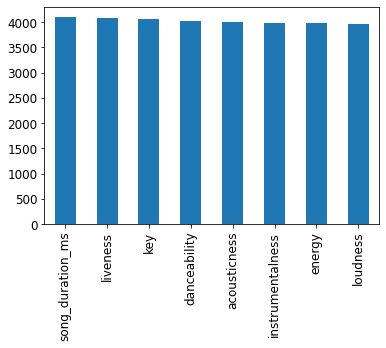

In [11]:
nans.plot(kind='bar')

###Data visualization

In [12]:
song_copy = song.copy() #Creating copy of the data

In [13]:
song_copy = song_copy.drop(['id', 'song_popularity'], axis=1) #Dropping id and target columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9195afee10>,
      dtype=object)

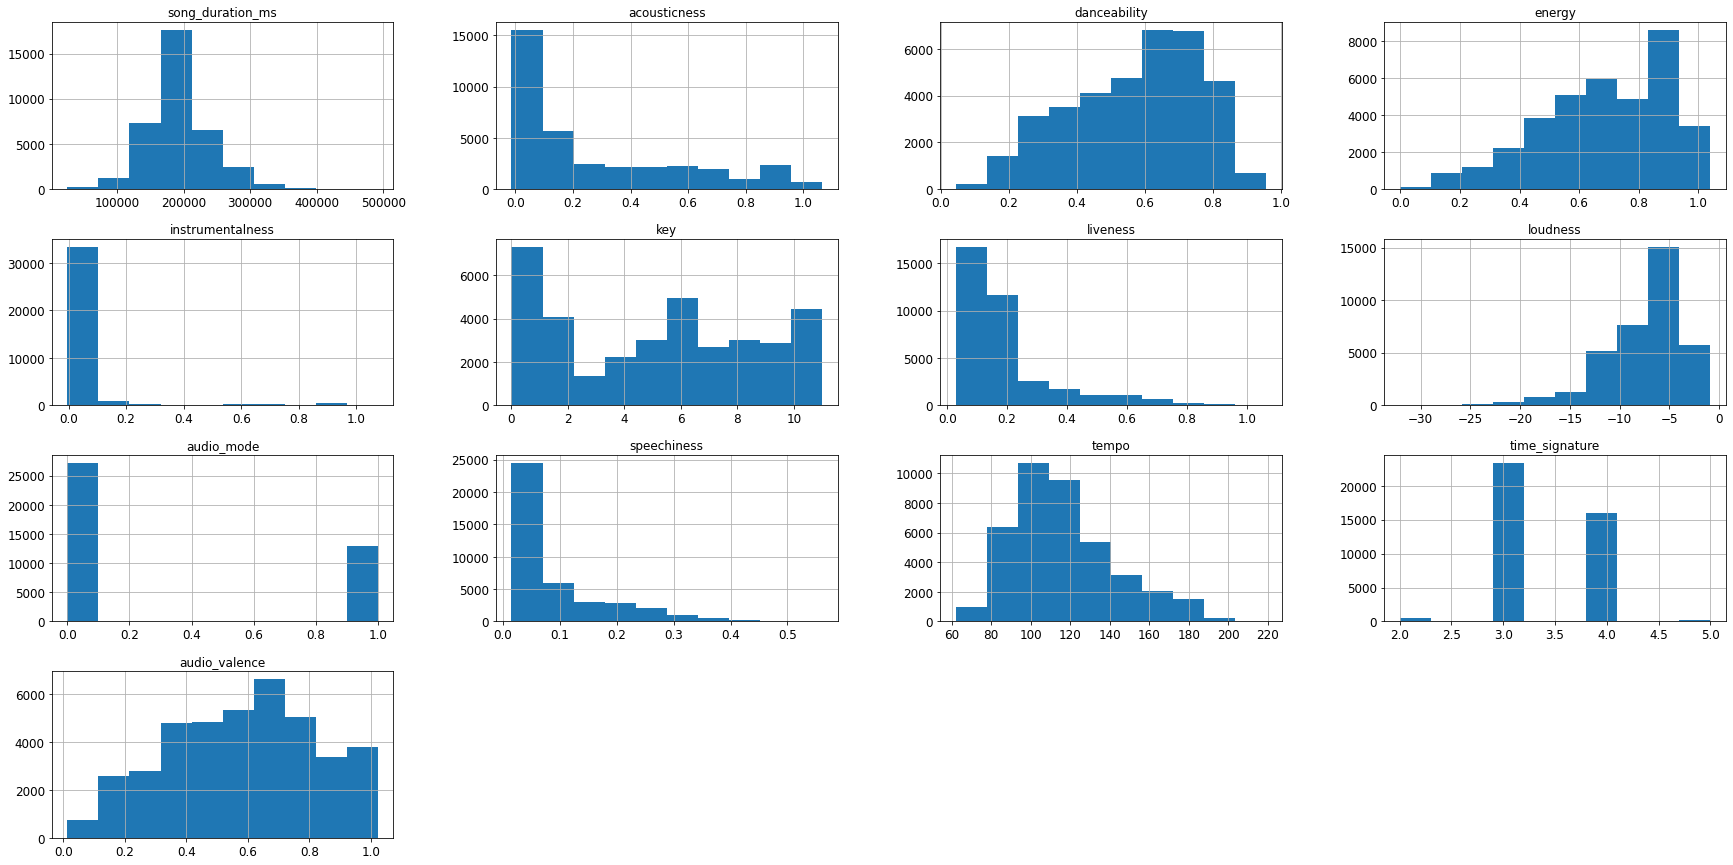

In [14]:
song_copy.hist(figsize=(30,15)) #Plotting histograms to the check distribution

Candidates for transformations: 

Normal ditibuted: song_duration



####Discrete variables plots

In [15]:
#Checking out unique values in discrete variables
num_categorical = ['audio_mode', 'time_signature', 'key']
for i in num_categorical:
  print(i, song[i].unique())

audio_mode [0 1]
time_signature [4 3 2 5]
key [10.  8.  5.  0.  4.  3. nan  6.  2.  7.  1.  9. 11.]


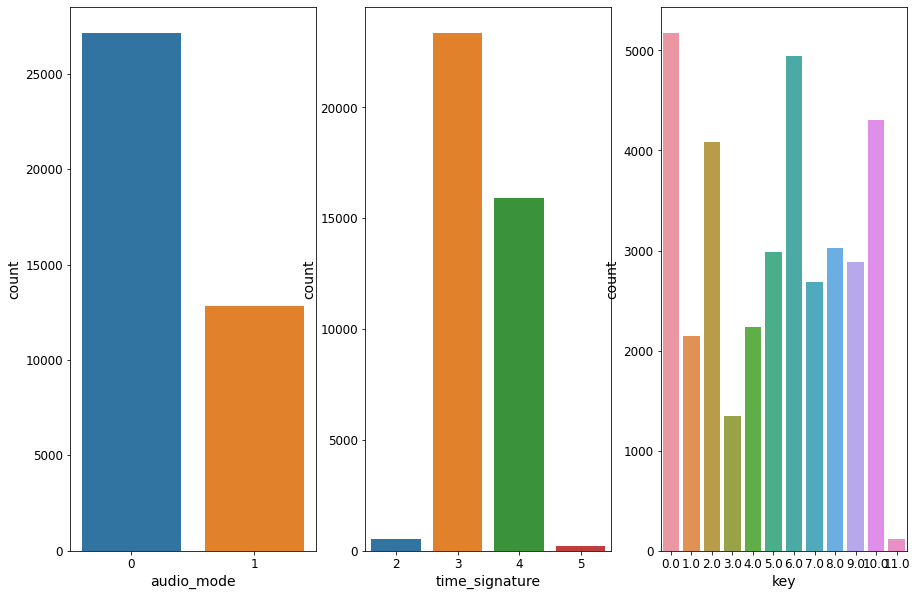

In [20]:
#Plotting discrete variables
fig, ax = plt.subplots(1,3, figsize=(15, 10))
sns.countplot(song['audio_mode'], ax=ax[0])
sns.countplot(song['time_signature'], ax=ax[1])
sns.countplot(song['key'], ax=ax[2])



####Target variable plot

It seems that we'are dealing with imbalanced, maybe some balancing should be in order. 

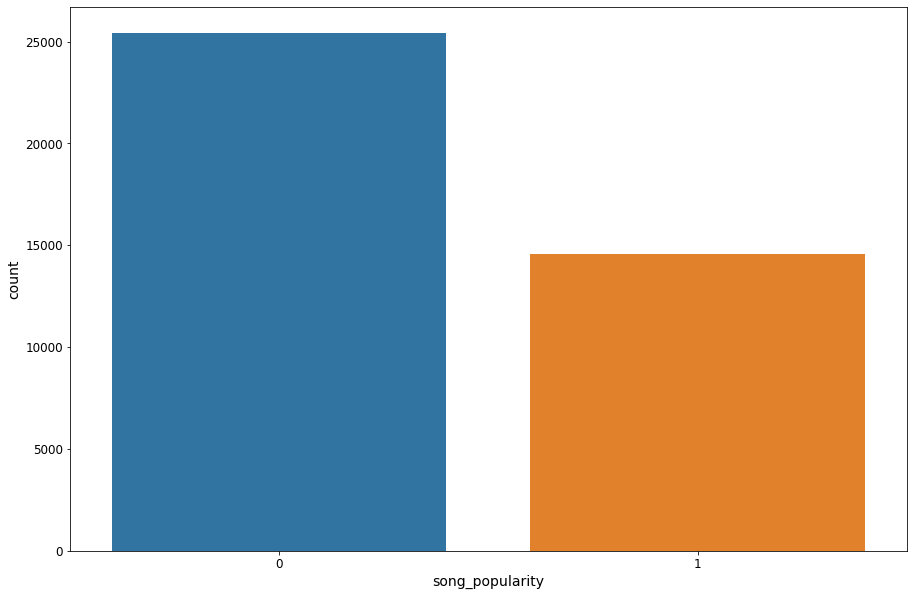

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(data=song, x='song_popularity')

###Correlations

In [18]:
corr_matrix = song.corr()

In [19]:
corr_matrix

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
id,1.000000,-0.004428,-0.002733,-0.003237,0.000051,0.001087,-0.001492,-0.004756,0.005135,0.002538,0.002792,-0.001297,-0.002199,-0.001016,-0.003074
song_duration_ms,-0.004428,1.000000,-0.166443,-0.061929,0.148531,-0.024337,0.019354,0.033009,0.152954,-0.017211,-0.001236,0.085490,0.021609,-0.006948,-0.003960
acousticness,-0.002733,-0.166443,1.000000,-0.093737,-0.570177,0.072516,-0.186663,-0.124704,-0.532724,0.066973,-0.130244,-0.190964,-0.205307,-0.250310,0.025298
danceability,-0.003237,-0.061929,-0.093737,1.000000,0.099933,-0.146447,0.120514,0.045400,0.200148,0.030289,0.177937,-0.089887,0.016455,0.384496,0.017572
energy,0.000051,0.148531,-0.570177,0.099933,1.000000,-0.120338,0.210176,0.154907,0.643931,-0.094916,0.120053,0.225465,0.238722,0.324626,-0.054640
instrumentalness,0.001087,-0.024337,0.072516,-0.146447,-0.120338,1.000000,-0.054726,-0.033445,-0.181889,-0.003617,-0.053209,-0.010350,-0.047397,-0.157760,-0.009511
key,-0.001492,0.019354,-0.186663,0.120514,0.210176,-0.054726,1.000000,0.077046,0.201509,-0.036252,0.102993,0.053206,0.094144,0.132194,0.017808
liveness,-0.004756,0.033009,-0.124704,0.045400,0.154907,-0.033445,0.077046,1.000000,0.146551,-0.013281,0.076612,0.064425,0.037766,0.084770,0.016571
loudness,0.005135,0.152954,-0.532724,0.200148,0.643931,-0.181889,0.201509,0.146551,1.000000,-0.076893,0.157550,0.173979,0.245403,0.356330,-0.040662
audio_mode,0.002538,-0.017211,0.066973,0.030289,-0.094916,-0.003617,-0.036252,-0.013281,-0.076893,1.000000,0.019790,-0.023202,-0.043714,-0.015683,-0.001455


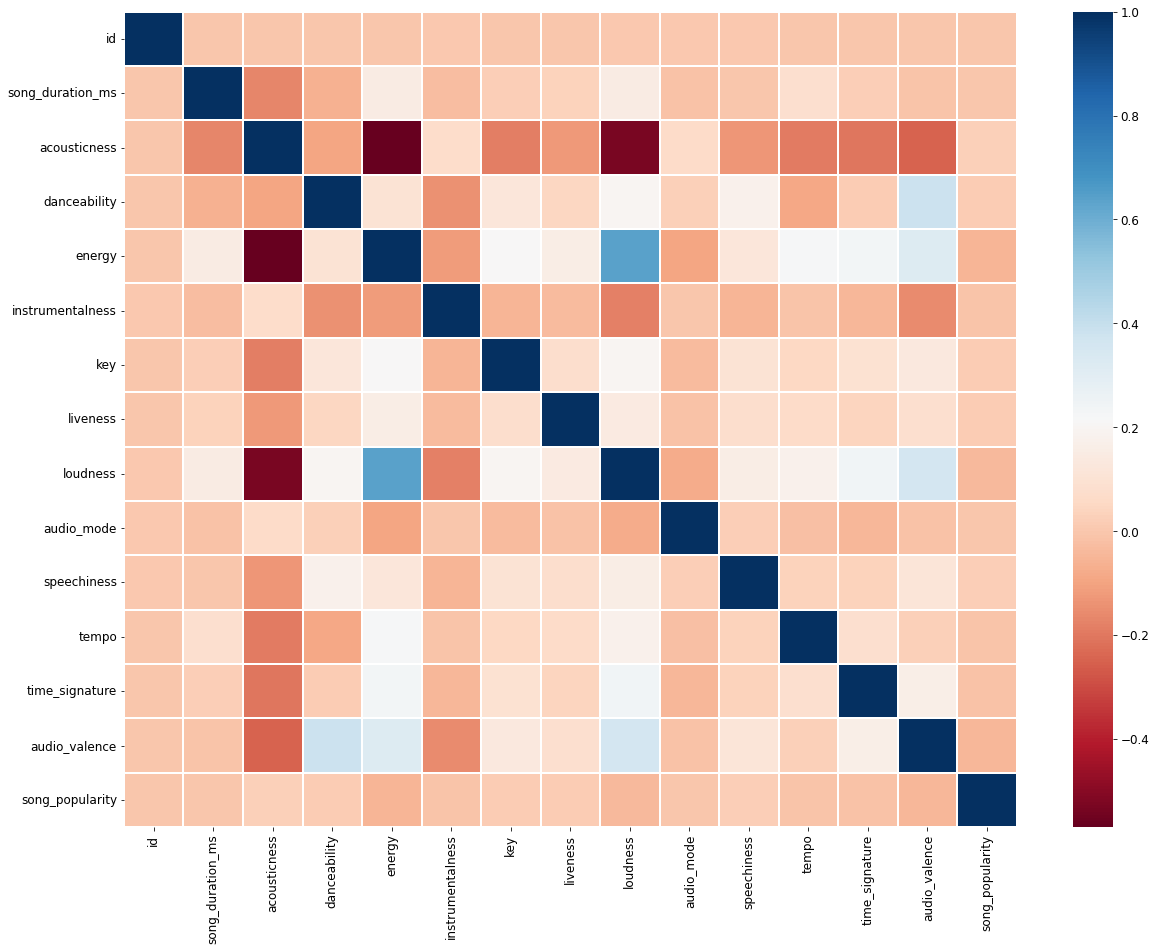

In [27]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='RdBu', linewidth=1)